In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [31]:
# Data transformer for converting images to tensors
data_transform = transforms.Compose([transforms.ToTensor()])

In [32]:
def load_data(train_batch_size, test_batch_size):
    """
    Load the dataset from MNIST for training and testing.

    Arguments are:
        train_batch_size (int): Batch size for training.
        test_batch_size (int): Batch size for testing.

    Returning:
        Tuple: Training and testing data loaders.
    """
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root='data', train=True, download=True, transform=data_transform),
        batch_size=train_batch_size, shuffle=True
    )
    
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root='data', train=False, download=True, transform=data_transform),
        batch_size=test_batch_size, shuffle=True
    )
    
    return train_loader, test_loader


In [33]:
class MLP(nn.Module):
    
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [34]:
def train(model, train_loader, optimizer, criterion, epochs=50):
    """
    Training the MLP model.

    Args are:
        model (nn.Module) is he model to be trained.
        train_loader (DataLoader) is DataLoader for training data.
        optimizer (Optimizer) is Optimizer for model training.
        criterion (nn.Module) is the Loss function.
        epochs (int) is the Number of training epochs.

    Returns:
        Tuple: Losses, accuracies, and weight updates across all epochs.
    """
    model.train()
    all_losses = []
    all_accuracies = []
    weight_updates_df = pd.DataFrame()
    
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        epoch_loss = 0.0
        correct_preds = 0
        total_samples = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            
            # Below we are Flattening the images into a single vector
            data = data.view(data.size(0), -1)
            predictions = model(data)
            
            # Below we are Computing the loss and perform backpropagation
            loss = criterion(predictions, target)
            loss.backward()
            optimizer.step()
            
            # Accumulate the loss for epoch
            epoch_loss += loss.item()

            # Calculation for accuracy
            _, predicted_labels = torch.max(predictions.data, 1)
            correct_preds += (predicted_labels == target).sum().item()
            total_samples += target.size(0)

        # Calculate and store the accuracy and loss
        accuracy = 100.0 * correct_preds / total_samples
        all_losses.append(epoch_loss)
        all_accuracies.append(round(accuracy, 3))

        print(f"Accuracy: {accuracy:.2f}%")

        # Save weights from the model after each epoch
        weights_df = pd.DataFrame()
        for name, param in model.named_parameters():
            if 'weight' in name:
                weight_vector = torch.nn.utils.parameters_to_vector(param).detach().numpy()
                weights_df = pd.concat([weights_df, pd.DataFrame(weight_vector).T], axis=1)

        weight_updates_df = pd.concat([weight_updates_df, weights_df], axis=0)

    return all_losses, all_accuracies, weight_updates_df

In [35]:
# Hyperparameters
train_batch_size = 1000
test_batch_size = 1000
learning_rate = 0.01
epochs = 50

# Loading the data
train_loader, test_loader = load_data(train_batch_size, test_batch_size)


In [36]:
# The Loss function
criterion = nn.CrossEntropyLoss()

# Below are used to store aggregated results across multiple runs
total_weight_updates = pd.DataFrame()
total_accuracies = []
total_losses = []

# Training loop across multiple runs
for run in range(8):
    print(f"Training Run {run + 1}")
    
    # Initialize the model and optimizer
    model = MLP()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train model
    run_losses, run_accuracies, run_weight_updates = train(model, train_loader, optimizer, criterion, epochs)
    
    # Aggregate results are
    total_losses.extend(run_losses)
    total_accuracies.extend(run_accuracies)
    total_weight_updates = pd.concat([total_weight_updates, run_weight_updates], axis=0)


Training Run 1
Epoch 1/50
Accuracy: 84.54%
Epoch 2/50
Accuracy: 94.18%
Epoch 3/50
Accuracy: 95.98%
Epoch 4/50
Accuracy: 96.89%
Epoch 5/50
Accuracy: 97.27%
Epoch 6/50
Accuracy: 97.82%
Epoch 7/50
Accuracy: 97.99%
Epoch 8/50
Accuracy: 98.45%
Epoch 9/50
Accuracy: 98.56%
Epoch 10/50
Accuracy: 98.72%
Epoch 11/50
Accuracy: 98.82%
Epoch 12/50
Accuracy: 98.90%
Epoch 13/50
Accuracy: 98.86%
Epoch 14/50
Accuracy: 99.06%
Epoch 15/50
Accuracy: 99.14%
Epoch 16/50
Accuracy: 99.38%
Epoch 17/50
Accuracy: 99.24%
Epoch 18/50
Accuracy: 99.28%
Epoch 19/50
Accuracy: 99.17%
Epoch 20/50
Accuracy: 99.23%
Epoch 21/50
Accuracy: 99.39%
Epoch 22/50
Accuracy: 99.33%
Epoch 23/50
Accuracy: 99.61%
Epoch 24/50
Accuracy: 99.54%
Epoch 25/50
Accuracy: 99.60%
Epoch 26/50
Accuracy: 99.49%
Epoch 27/50
Accuracy: 99.50%
Epoch 28/50
Accuracy: 99.27%
Epoch 29/50
Accuracy: 99.37%
Epoch 30/50
Accuracy: 99.42%
Epoch 31/50
Accuracy: 99.47%
Epoch 32/50
Accuracy: 99.60%
Epoch 33/50
Accuracy: 99.72%
Epoch 34/50
Accuracy: 99.66%
Epoch 35

In [37]:
# Convert weight updates DataFrame to a NumPy array
weights_array = np.array(total_weight_updates)
print("Weights array shape:", weights_array.shape)

# Perform PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(weights_array)

# Creating a DataFrame for the PCA-transformed weights
pca_df = pd.DataFrame(pca_transformed, columns=['x', 'y'])
print("PCA DataFrame shape:", pca_df.shape)

# Adding accuracy and loss columns to the PCA DataFrame
pca_df["accuracy"] = total_accuracies
pca_df["loss"] = total_losses

# Output the final PCA DataFrame with accuracy and loss
print(pca_df)


Weights array shape: (400, 52544)
PCA DataFrame shape: (400, 2)
             x          y  accuracy       loss
0    -6.699408   6.516887    84.537  31.521171
1    -9.481551  10.235119    94.180  11.870165
2   -11.841176  13.547728    95.978   8.146022
3   -14.019389  16.495836    96.887   6.236840
4   -16.186691  19.229158    97.273   5.254651
..         ...        ...       ...        ...
395 -30.861155 -44.129723    99.257   1.513053
396 -31.208649 -44.678913    99.482   0.945065
397 -31.574684 -45.109509    99.540   0.897028
398 -31.854103 -45.424744    99.622   0.656448
399 -32.098587 -45.780167    99.682   0.531612

[400 rows x 4 columns]


In [38]:
final_pca = pca_df.iloc[::3, :]
print(final_pca)

             x          y  accuracy       loss
0    -6.699408   6.516887    84.537  31.521171
3   -14.019389  16.495836    96.887   6.236840
6   -20.023087  23.938900    97.992   3.770286
9   -24.618465  29.603102    98.715   2.361427
12  -28.768114  34.503281    98.860   1.999745
..         ...        ...       ...        ...
387 -27.915041 -39.977776    99.855   0.253738
390 -28.780424 -41.013248    99.568   0.767676
393 -30.181053 -43.064156    99.392   1.236576
396 -31.208649 -44.678913    99.482   0.945065
399 -32.098587 -45.780167    99.682   0.531612

[134 rows x 4 columns]


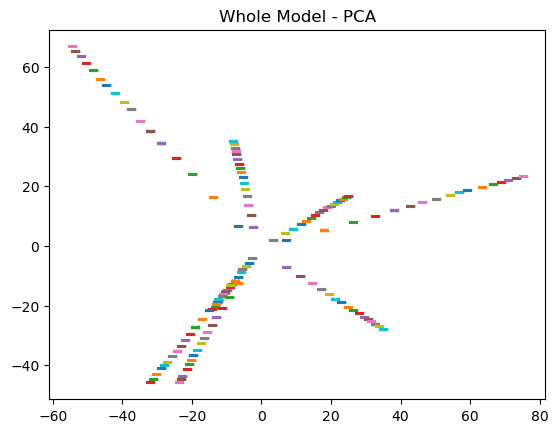

In [39]:
for i in range(final_pca.shape[0]):
    m = list(final_pca['accuracy'])[i]
    plt.scatter(final_pca['x'][i*3], final_pca['y'][i*3], marker = f'${m}$')
    plt.title("Whole Model - PCA")